# Group spectral-peak detections on all geophone stations by time and frequency

In [1]:
# Imports
from os.path import join
from numpy import linspace
from pandas import read_csv, Grouper, cut, date_range, Timestamp, Timedelta

from utils_basic import SPECTROGRAM_DIR as indir, GEO_STATIONS as stations
from utils_spec import assemble_spec_filename, read_geo_spectrograms, find_geo_station_spectral_peaks
from utils_plot import plot_array_spec_peak_detect_counts, save_figure

In [2]:
# Inputs
# Data
day_suffices = [ "20200113" ]
window_length = 60.0
overlap = 0.0
downsample = True
downsample_factor = 60
prom_threshold = 5
rbw_threshold = 0.2

# Grouping
time_bin_width = 1.0 # in minutes
freq_bin_width = 1.0 # in Hz
minfreq = 0.0
maxfreq = 500.0

# Directory
indir = join(indir, "daily")

# Plotting
day_to_plot = "2020-01-13"
min_count = 0
max_count = 35

Processing day 2020-01-13


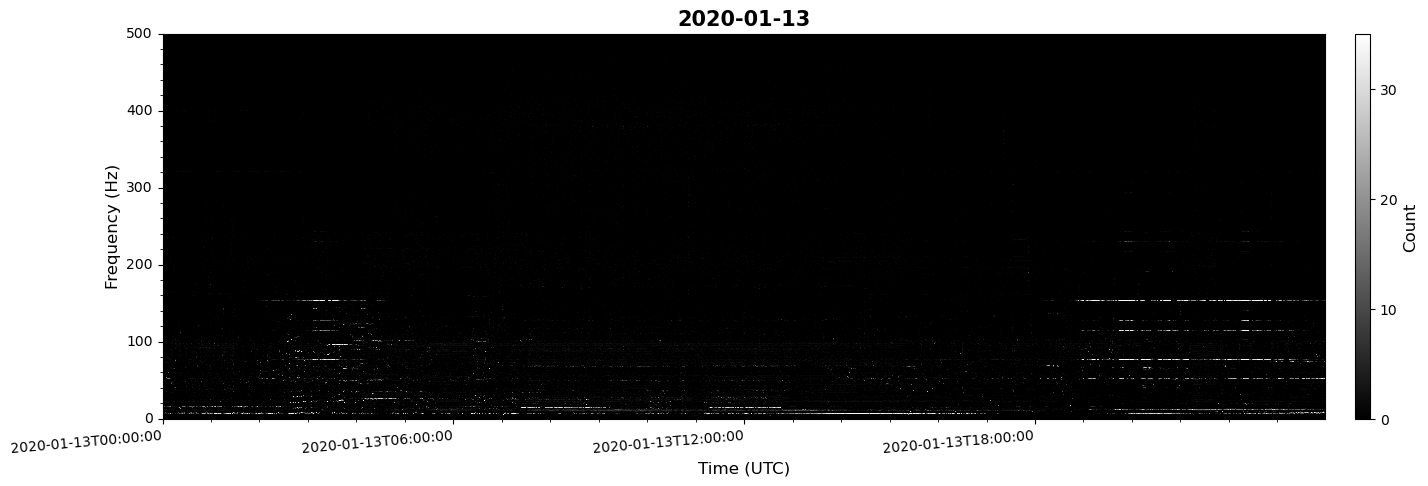

In [3]:
# Define the frequency bin edges and centers
num_freq_bins = int((maxfreq - minfreq) / freq_bin_width)
freq_bin_edges = linspace(minfreq, maxfreq, num_freq_bins + 1)
freq_bin_centers = freq_bin_edges + freq_bin_width / 2
freq_bin_centers = freq_bin_centers[:-1]

for day_suffix in day_suffices:
    day = Timestamp(day_suffix).strftime("%Y-%m-%d")
    print(f"Processing day {day}")

    # Read the CSV files containing the spectral peaks
    filename = f"daily_geo_spectral_peaks_{day_suffix}_window{window_length:.0f}_overlap{overlap:.1f}_prom{prom_threshold:.0f}_rbw{rbw_threshold:.1f}.csv"
    inpath = join(indir, filename)
    peak_df = read_csv(inpath, index_col = 0, parse_dates = ['time'])
    
    # Group the detections by time and frequency
    starttime = Timestamp(day)
    endtime = starttime.replace(hour = 23, minute = 59, second = 59, microsecond = 999999)
    time_bin_edges = date_range(starttime, endtime, freq='1min')
    peak_df['time_bin'] = cut(peak_df["time"], time_bin_edges, include_lowest=True, right=False)
    peak_df['freq_bin'] = cut(peak_df["frequency"], freq_bin_edges, include_lowest=True, right=False)
    
    grouped = peak_df.groupby(['time_bin', 'freq_bin'], observed = False).size().unstack(fill_value=0)

    if day == day_to_plot:
        detect_counts = grouped.values
        detect_counts = detect_counts.T

        time_bin_centers = [time + Timedelta(minutes=time_bin_width) / 2 for time in time_bin_edges]
        time_bin_centers = time_bin_centers[:-1]

        fig, ax, cbar = plot_array_spec_peak_detect_counts(time_bin_centers, freq_bin_centers, detect_counts, min_count = min_count, max_count = max_count)
    

In [4]:
# Save the figure
figname = f"daily_geo_array_spectral_peak_detections_{day}.png"
save_figure(fig, figname)

Figure saved to /fp/projects01/ec332/data/figures/daily_geo_array_spectral_peak_detections_2020-01-13.png
